# Applied Physics Lab - II. Optical Pumping @ ELTE
## Exponential curve fitting to determine $T_{p}$ and $T_{2}$ characteristic times

In [253]:
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import curve_fit

In [293]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [318]:
PC = True
if PC:
    OPU_dir = 'D://GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/data/'
    figsave_dir = 'D://GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/Documentation/report/src/images/'
else:
    OPU_dir = 'C://Users/masterdesky/Documents/GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/data/'
    figsave_dir = 'C://Users/masterdesky/Documents/GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/Documentation/report/src/images/'

figsave_format = 'pdf'
figsave_dpi = 200
    
# Bold print
b1 = '\033[1m'
b0 = '\033[0m'

## Import data

In [319]:
os.listdir(OPU_dir)

['earth_mag_1.csv',
 'earth_mag_T.csv',
 'freq_4_1.csv',
 'freq_6_1.csv',
 'freq_7_1.csv',
 'freq_8_1.csv',
 'state_4_1.csv',
 'state_4_2.csv',
 'state_4_T.csv',
 'state_6_1.csv',
 'state_6_2.csv',
 'state_6_T.csv',
 'state_7_1.csv',
 'state_7_2.csv',
 'state_7_T.csv',
 'state_8_1.csv',
 'state_8_2.csv',
 'state_8_T.csv',
 'tau_1.csv',
 'tau_2.csv',
 'tau_T.csv',
 'test1.csv',
 'test2.csv']

In [320]:
def read_data_files(file):
    
    header = {}
    time = []
    values = []
    
    with open(file, mode='rt') as f:
        for idx, line in enumerate(f):

            # Skip 16 header lines (indexing from 0 - 15)
            if(idx < 16):
                s = line.split(',')
                header[s[0]] = s[1]
                continue

            # Dataline format:
            # "vvvv, tttt,"
            # 
            s = line.split(',')
            # The first element will contain the time label, while
            # the second element contains the quantity's value
            # s[0] == time
            # s[1] == value
            time.append(float(s[0]))
            values.append(float(s[1]))
            
    # Convert to numpy array
    time = np.array(time)
    values = np.array(values)
    
    # Shift time to 0
    time -= np.min(time)

    return time, values, header

In [321]:
time_T, values_T, header_T = read_data_files(file=OPU_dir + 'tau_T.csv')
time_1, values_1, header_1 = read_data_files(file=OPU_dir + 'tau_1.csv')
time_2, values_2, header_2 = read_data_files(file=OPU_dir + 'tau_2.csv')

In [322]:
header_T

{'Memory Length': '4000',
 'Trigger Level': '-2.800E-01',
 'Source': 'CH1',
 'Probe': '10X',
 'Vertical Units': 'V',
 'Vertical Scale': '2.000E+00',
 'Vertical Position': '8.800E-01',
 'Horizontal Units': 'S',
 'Horizontal Scale': '2.500E-03',
 'Horizontal Position': '1.700E-03',
 'Horizontal Mode': 'Main',
 'Sampling Period': '1E-05',
 'Firmware': 'V1.23',
 'Time': ' 09:38:41',
 'Mode': 'Detail',
 'Waveform Data': '\n'}

In [323]:
header_1

{'Memory Length': '4000',
 'Trigger Level': '-2.800E-01',
 'Source': 'CH2',
 'Probe': '1X',
 'Vertical Units': 'V',
 'Vertical Scale': '2.000E-03',
 'Vertical Position': '0.000E+00',
 'Horizontal Units': 'S',
 'Horizontal Scale': '2.500E-03',
 'Horizontal Position': '1.700E-03',
 'Horizontal Mode': 'Main',
 'Sampling Period': '1E-05',
 'Firmware': 'V1.23',
 'Time': ' 09:39:35',
 'Mode': 'Detail',
 'Waveform Data': '\n'}

In [324]:
header_2

{'Memory Length': '4000',
 'Trigger Level': '-2.800E-01',
 'Source': 'CH2',
 'Probe': '1X',
 'Vertical Units': 'V',
 'Vertical Scale': '2.000E-03',
 'Vertical Position': '0.000E+00',
 'Horizontal Units': 'S',
 'Horizontal Scale': '2.500E-03',
 'Horizontal Position': '1.700E-03',
 'Horizontal Mode': 'Main',
 'Sampling Period': '1E-05',
 'Firmware': 'V1.23',
 'Time': ' 09:39:56',
 'Mode': 'Detail',
 'Waveform Data': '\n'}

## Determination of $T_p$
### 1) Full Signal

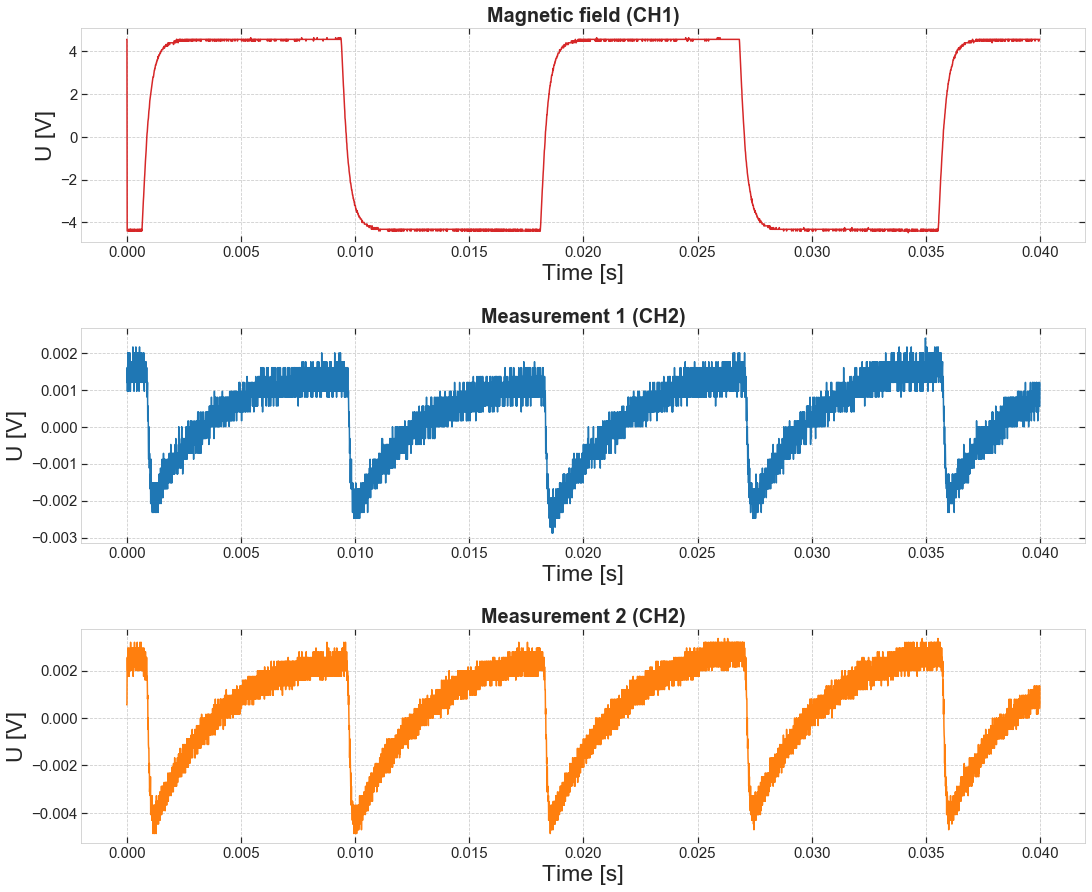

In [349]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

axislabelsize = 23
axisticksize = 15

axes[0].plot(time_T, values_T, color='tab:red')
axes[0].set_title('Magnetic field (CH1)', fontsize=titlesize, fontweight='bold')

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[time_1, values_1], [time_2, values_2]]):
    axes[idx+1].plot(params[0], params[1], color=colors[idx])

    axes[idx+1].set_title('Measurement {0} (CH2)'.format(idx+1), fontsize=titlesize, fontweight='bold')

for i in range(nrows):
    axes[i].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[i].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'tau.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### Fourier space

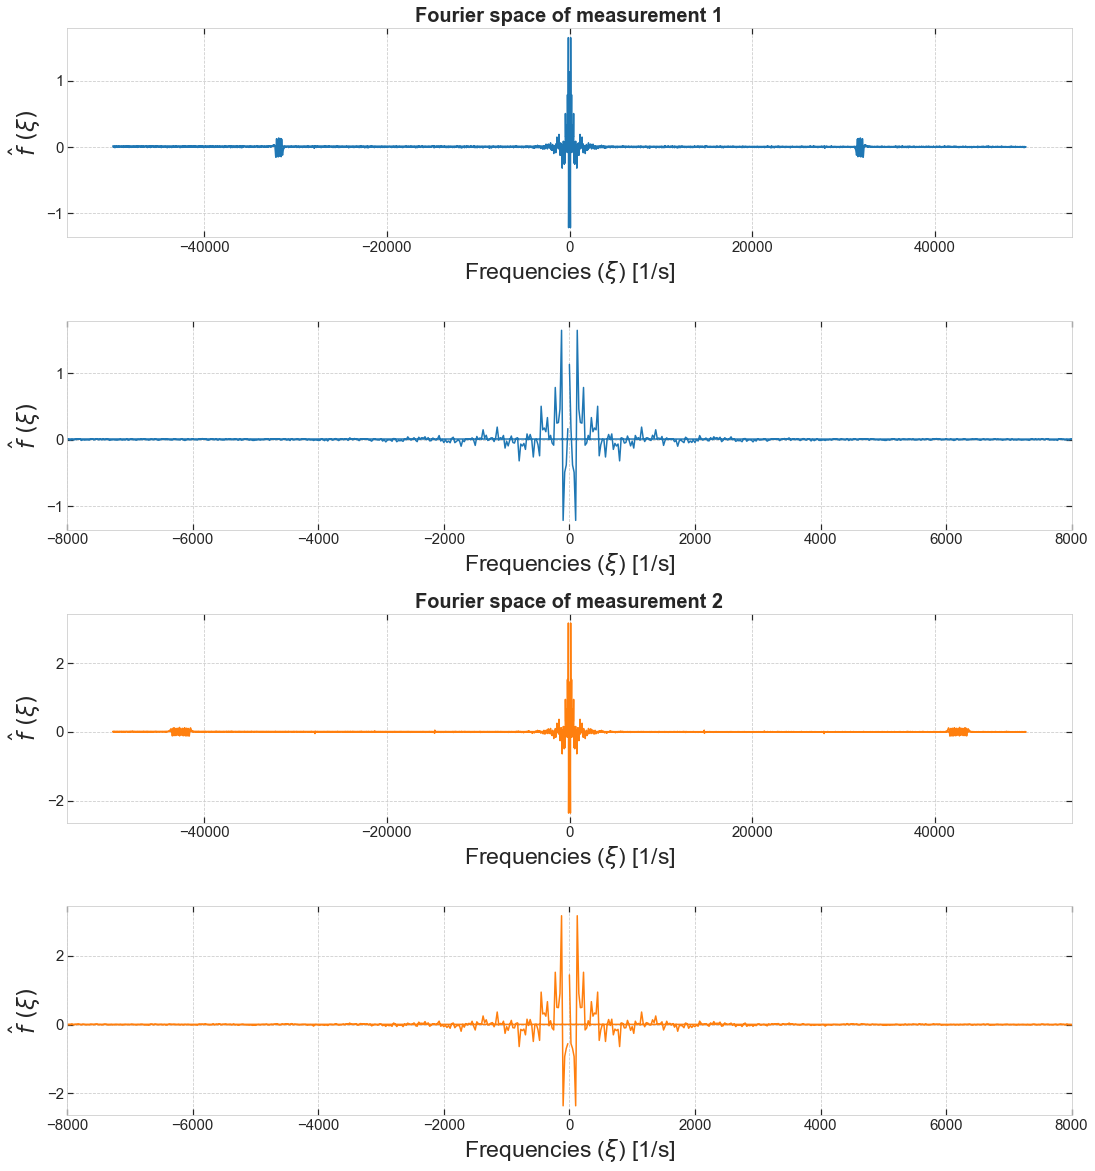

In [350]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier_1 = np.fft.fft(values_1)
freq_1 = np.fft.fftfreq(values_1.size, d=float(header_1['Sampling Period']))
fourier_2 = np.fft.fft(values_2)
freq_2 = np.fft.fftfreq(values_2.size, d=float(header_2['Sampling Period']))

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[freq_1, fourier_1.real], [freq_2, fourier_2.real]]):
    axes[2*idx].plot(params[0], params[1], color=colors[idx])
    axes[2*idx+1].plot(params[0], params[1], color=colors[idx])

for i in range(nrows):
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
axes[0].set_title('Fourier space of measurement 1', fontsize=titlesize, fontweight='bold')
axes[2].set_title('Fourier space of measurement 2', fontsize=titlesize, fontweight='bold')
    
freq_lim = 8000
axes[1].set_xlim(-freq_lim, freq_lim)
axes[3].set_xlim(-freq_lim, freq_lim)

plt.savefig(figsave_dir + 'tau_fourier.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### Convolution of T and U

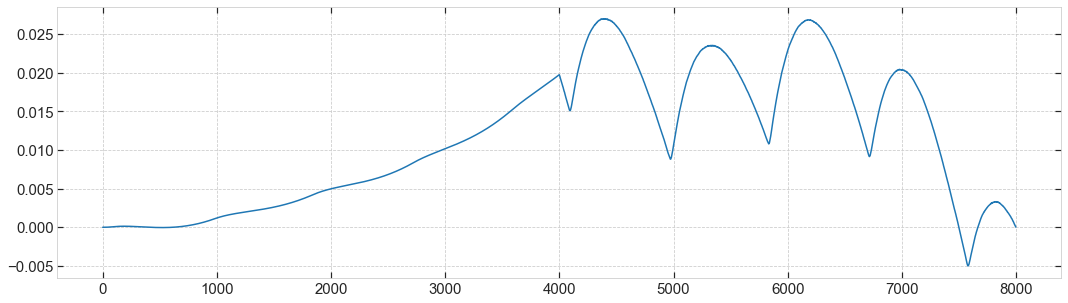

In [351]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 23
axisticksize = 15

axes.plot(np.convolve(time_1, values_1))

axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

#### LP Butterworth

- https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [413]:
# Sampling frequency
fs_1 = 1/float(header_1['Sampling Period'])
fs_2 = 1/float(header_2['Sampling Period'])
# Cut-off frequency of the filter
fc_1 = 1000
fc_2 = 1000
# Normalize the frequency
w_1 = fc_1 / (fs_1 / 2)
w_2 = fc_1 / (fs_2 / 2)
# Butterworth filter
b_1, a_1 = signal.butter(5, w_1, 'low')
b_2, a_2 = signal.butter(5, w_2, 'low')
output_1 = signal.filtfilt(b_1, a_1, values_1)
output_2 = signal.filtfilt(b_2, a_2, values_2)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


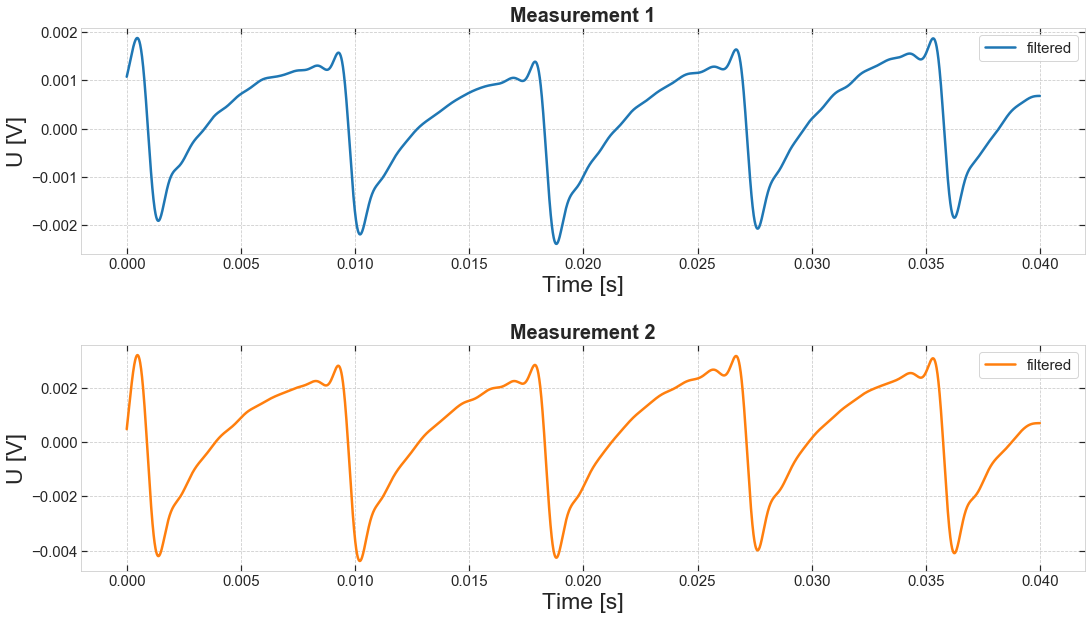

In [416]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[time_1, output_1], [time_2, output_2]]):
    axes[idx].plot(params[0], params[1],
                   lw=2.5, color=colors[idx], label='filtered')

    axes[idx].set_title('Measurement {0}'.format(idx+1), fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper right', fontsize=legendsize)

plt.savefig(figsave_dir + 'tau_butterworth.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### Fourier space - Low pass filter

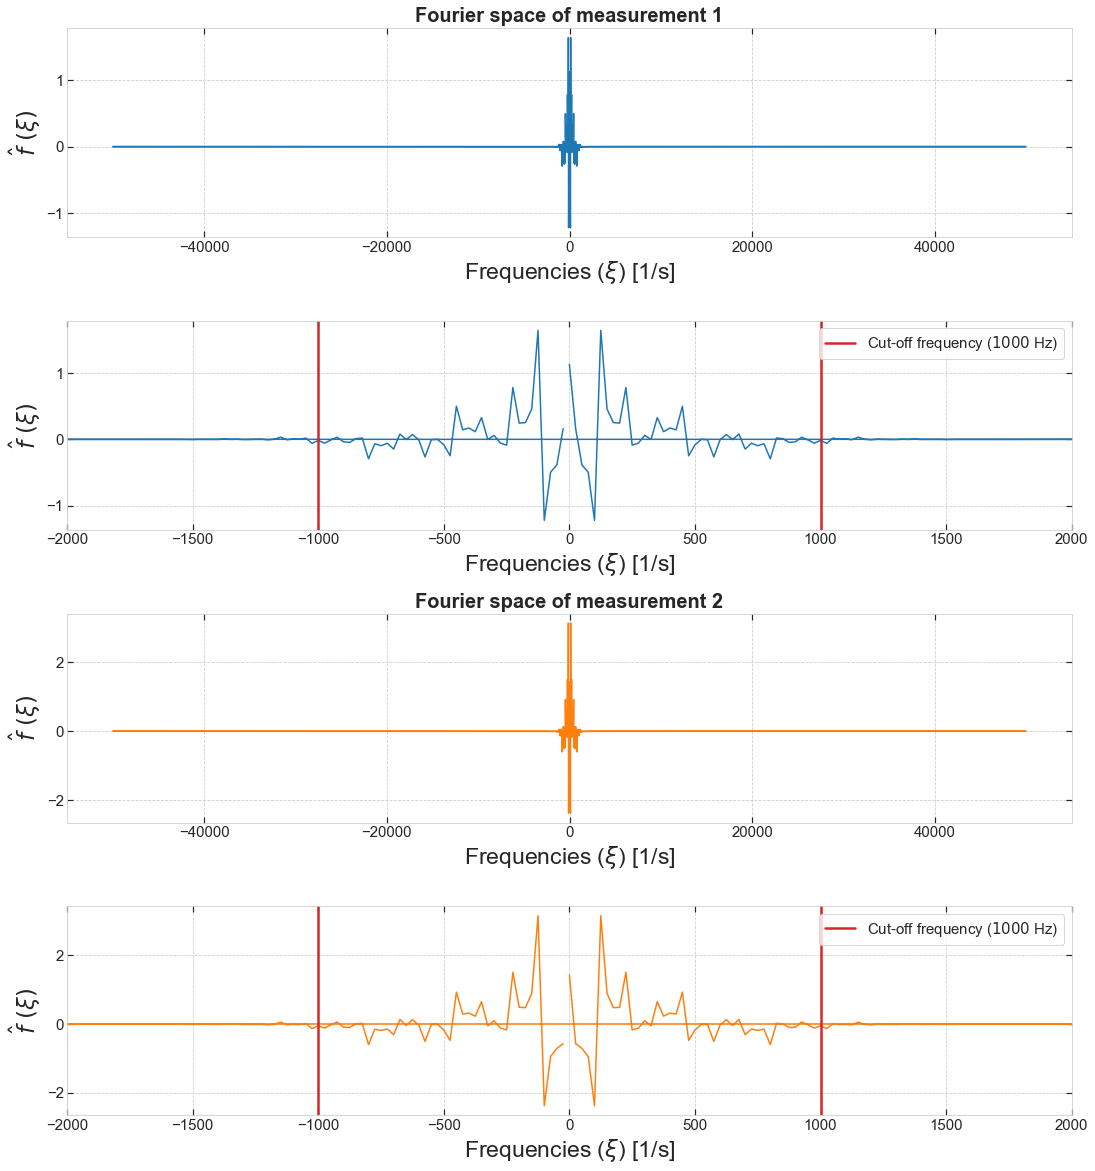

In [422]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier_1 = np.fft.fft(output_1)
freq_1 = np.fft.fftfreq(output_1.size, d=float(header_1['Sampling Period']))
fourier_2 = np.fft.fft(output_2)
freq_2 = np.fft.fftfreq(output_2.size, d=float(header_2['Sampling Period']))

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[freq_1, fourier_1.real], [freq_2, fourier_2.real]]):
    axes[2*idx].plot(params[0], params[1], color=colors[idx])
    axes[2*idx+1].plot(params[0], params[1], color=colors[idx])

for i in range(nrows):
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
axes[0].set_title('Fourier space of measurement 1', fontsize=titlesize, fontweight='bold')
axes[2].set_title('Fourier space of measurement 2', fontsize=titlesize, fontweight='bold')
    
freq_lim_1 = 2*fc_1
freq_lim_2 = 2*fc_2
axes[1].set_xlim(-freq_lim_1, freq_lim_1)
axes[3].set_xlim(-freq_lim_2, freq_lim_2)

# Draw frequency cutoffs
axes[1].axvline(x=-fc_1, color='tab:red', label='Cut-off frequency (${0}$ Hz)'.format(fc_1), lw=2.5)
axes[1].axvline(x=fc_1, color='tab:red', lw=2.5)
axes[3].axvline(x=-fc_2, color='tab:red', label='Cut-off frequency (${0}$ Hz)'.format(fc_2), lw=2.5)
axes[3].axvline(x=fc_2, color='tab:red', lw=2.5)

axes[1].legend(loc='upper right', fontsize=legendsize)
axes[3].legend(loc='upper right', fontsize=legendsize)

plt.savefig(figsave_dir + 'tau_butterworth_fourier.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

### 2) Sliced signal

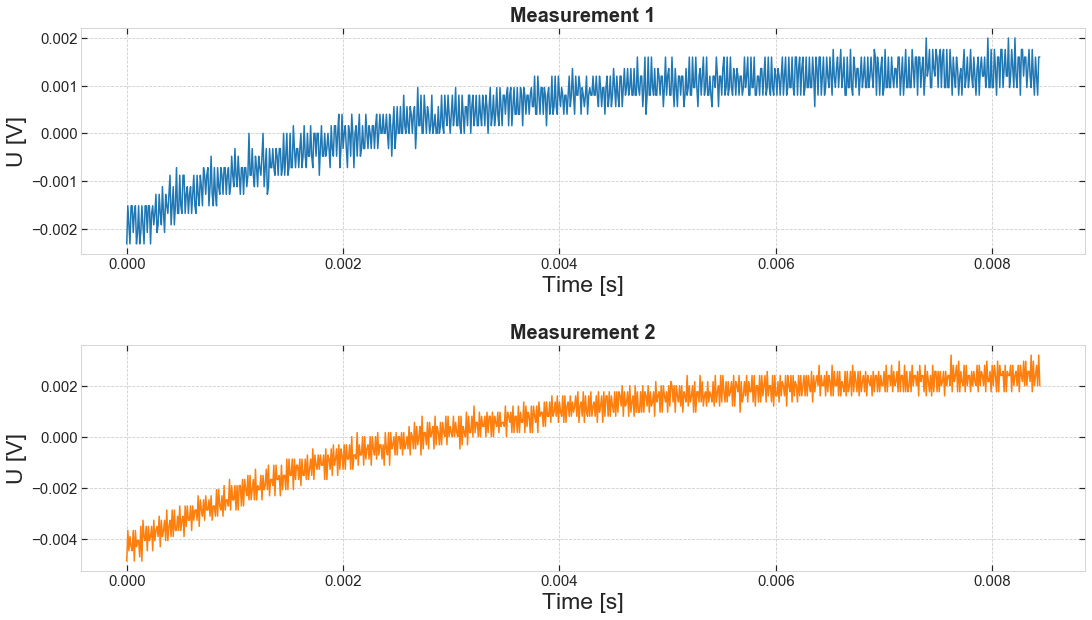

In [410]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

axislabelsize = 23
axisticksize = 15

# tau: lower=115, upper=960
lower_1 = 115; lower_2 = 115
upper_1 = 960; upper_2 = 960

time_var_1 = np.array(time_1[lower_1:upper_1])
time_var_1 -= np.min(time_var_1)
values_var_1 = np.array(values_1[lower_1:upper_1])
time_var_2 = np.array(time_2[lower_2:upper_2])
time_var_2 -= np.min(time_var_2)
values_var_2 = np.array(values_2[lower_2:upper_2])

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[time_var_1, values_var_1], [time_var_2, values_var_2]]):
    axes[idx].plot(params[0], params[1], color=colors[idx])

    axes[idx].set_title('Measurement {0}'.format(idx+1), fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'tau_sliced.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### Fourier space

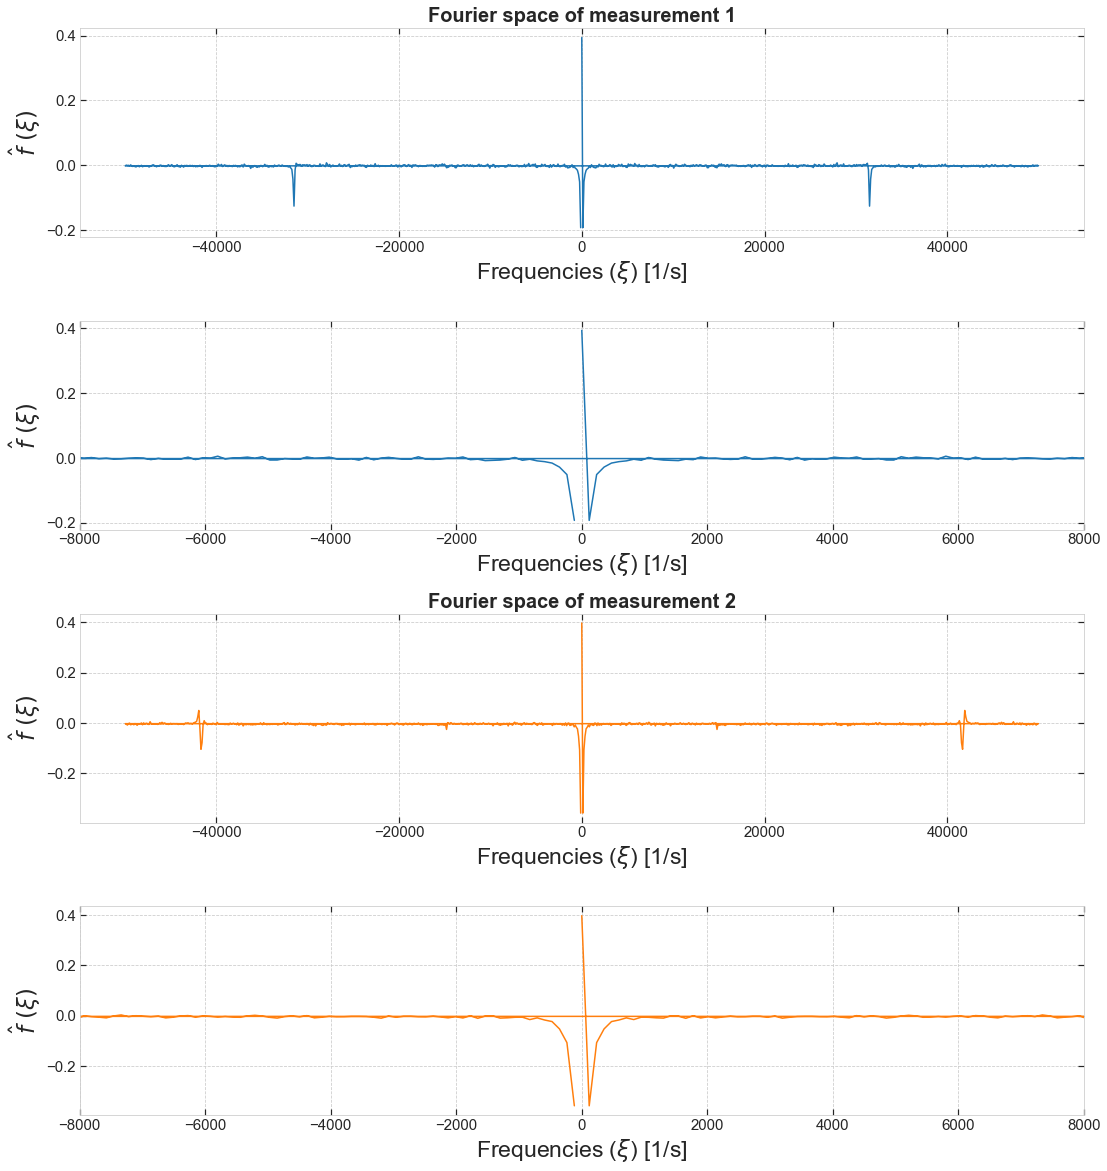

In [423]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier_1 = np.fft.fft(values_var_1)
freq_1 = np.fft.fftfreq(values_var_1.size, d=float(header_1['Sampling Period']))
fourier_2 = np.fft.fft(values_var_2)
freq_2 = np.fft.fftfreq(values_var_2.size, d=float(header_2['Sampling Period']))

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[freq_1, fourier_1.real], [freq_2, fourier_2.real]]):
    axes[2*idx].plot(params[0], params[1], color=colors[idx])
    axes[2*idx+1].plot(params[0], params[1], color=colors[idx])

for i in range(nrows):
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
axes[0].set_title('Fourier space of measurement 1', fontsize=titlesize, fontweight='bold')
axes[2].set_title('Fourier space of measurement 2', fontsize=titlesize, fontweight='bold')
    
freq_lim = 8000
axes[1].set_xlim(-freq_lim, freq_lim)
axes[3].set_xlim(-freq_lim, freq_lim)

plt.savefig(figsave_dir + 'tau_sliced_fourier.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### LP Butterworth

- https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [411]:
# Sampling frequency
fs_1 = 1/float(header_1['Sampling Period'])
fs_2 = 1/float(header_2['Sampling Period'])
# Cut-off frequency of the filter
fc_1 = 1000
fc_2 = 1000
# Normalize the frequency
w_1 = fc_1 / (fs_1 / 2)
w_2 = fc_1 / (fs_2 / 2)
# Butterworth filter
b_1, a_1 = signal.butter(5, w_1, 'low')
b_2, a_2 = signal.butter(5, w_2, 'low')
output_var_1 = signal.filtfilt(b_1, a_1, values_var_1)
output_var_2 = signal.filtfilt(b_2, a_2, values_var_2)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


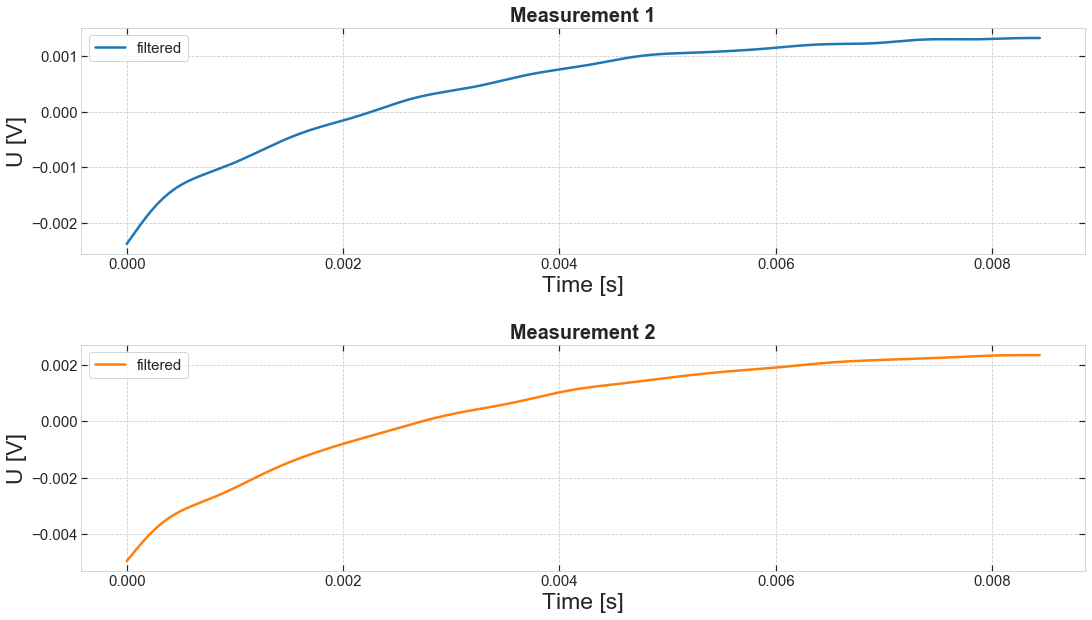

In [417]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[time_var_1, output_var_1], [time_var_2, output_var_2]]):
    axes[idx].plot(params[0], params[1],
                   lw=2.5, color=colors[idx], label='filtered')

    axes[idx].set_title('Measurement {0}'.format(idx+1), fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper left', fontsize=legendsize)

plt.savefig(figsave_dir + 'tau_sliced_butterworth.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

#### Fourier space - Low pass filter

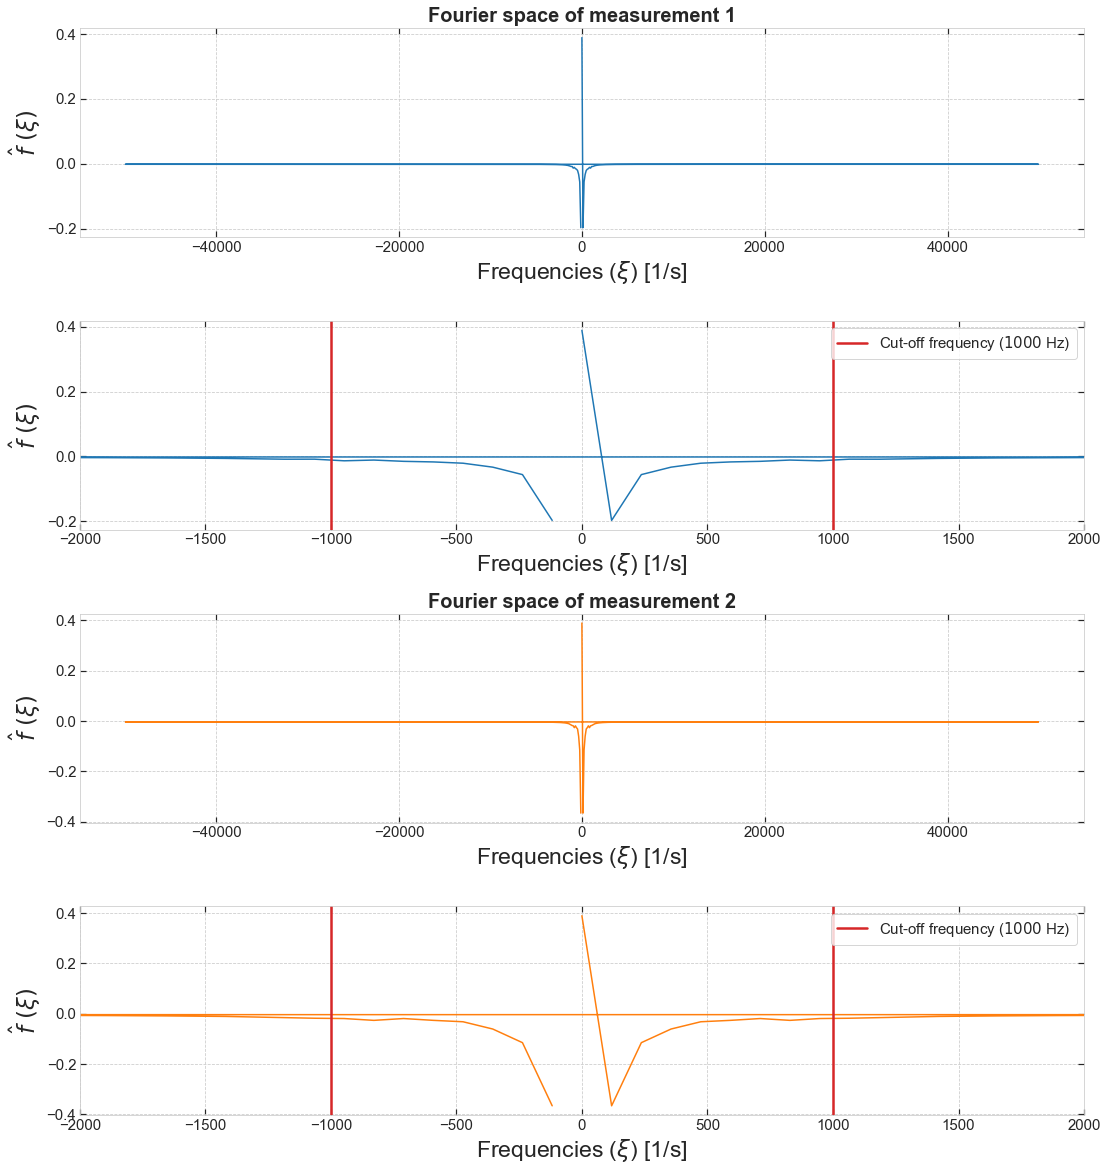

In [420]:
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier_1 = np.fft.fft(output_var_1)
freq_1 = np.fft.fftfreq(output_var_1.size, d=float(header_1['Sampling Period']))
fourier_2 = np.fft.fft(output_var_2)
freq_2 = np.fft.fftfreq(output_var_2.size, d=float(header_2['Sampling Period']))

colors = ['tab:blue', 'tab:orange']
for idx, params in enumerate([[freq_1, fourier_1.real], [freq_2, fourier_2.real]]):
    axes[2*idx].plot(params[0], params[1], color=colors[idx])
    axes[2*idx+1].plot(params[0], params[1], color=colors[idx])

for i in range(nrows):
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
axes[0].set_title('Fourier space of measurement 1', fontsize=titlesize, fontweight='bold')
axes[2].set_title('Fourier space of measurement 2', fontsize=titlesize, fontweight='bold')
    
freq_lim_1 = 2*fc_1
freq_lim_2 = 2*fc_2
axes[1].set_xlim(-freq_lim_1, freq_lim_1)
axes[3].set_xlim(-freq_lim_2, freq_lim_2)

# Draw frequency cutoffs
axes[1].axvline(x=-fc_1, color='tab:red', label='Cut-off frequency (${0}$ Hz)'.format(fc_1), lw=2.5)
axes[1].axvline(x=fc_1, color='tab:red', lw=2.5)
axes[3].axvline(x=-fc_2, color='tab:red', label='Cut-off frequency (${0}$ Hz)'.format(fc_2), lw=2.5)
axes[3].axvline(x=fc_2, color='tab:red', lw=2.5)

axes[1].legend(loc='upper right', fontsize=legendsize)
axes[3].legend(loc='upper right', fontsize=legendsize)

plt.savefig(figsave_dir + 'tau_sliced_butterworth_fourier.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

### Fit exponential on sliced signal

In [271]:
def fit_func(t, A, B, C):
    #return A + B * np.e ** (C * t + offset)
    return A + B * np.e ** (C * t)

In [272]:
def value_prep(time, values, prep=10, offset=0):
    """
    Prepares initial values for fitting exponential on input data
    with `scipy.curve_fit()`.

    Parameters
    ----------
    time : array, shape = [n_samples]
        Array of time values. Length should be identical to the values'
        array.
    values : array, shape = [n_samples]
        Array of measured values. Length should be identical to the time
        values' array.
    prep : int, initial value ``prep = 10``
        Sets the windows size for calculating the mean of short
        intervals to determine fitting coefficients.
    offset : int, optional
        Doesn't matter now.

    Returns
    -------
    A, B, C : floats
        Initial coefficients for scipy exponential fit.
    """
    # t = inf: exp(C * inf + offset) = 0
    # f(inf) = A
    A = values[-prep:].mean()

    # t = 0: exp(C * 0 + offset) = 1
    # f(0) = A + B
    B = values[:prep].mean() - A

    # t = general solution:
    # f(t) = A + B * np.e ** (C * t + offset)
    # C = ln((f(t) - A) / B) / t
    dt = len(values) // 2
    C = np.log((values[dt:dt + prep].mean() - A) / B) / time[dt:dt+prep].mean()
    
    return A, B, C

#### 1) Cut only

In [462]:
p0_1 = value_prep(time=time_var_1, values=values_var_1, prep=10, offset=0)
popt_1, pcov_1 = curve_fit(fit_func, time_var_1, values_var_1, p0=p0_1)
perr_1 = np.sqrt(np.diag(pcov_1))
p0_2 = value_prep(time=time_var_2, values=values_var_2, prep=10, offset=0)
popt_2, pcov_2 = curve_fit(fit_func, time_var_2, values_var_2, p0=p0_2)
perr_2 = np.sqrt(np.diag(pcov_2))

# REPORTING AFTER FITTING
# Measurement 1
print(b1 + 'Starting equation (Meas. 1)' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0_1[0], p0_1[1], p0_1[2]))
print(b1 + 'Final equation (Meas. 1)' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                                        '({2:.5f} +- {3:.5f}) * ' +
                                                        'e^(({4:.5f} +- {5:.5f}) * t)').format(popt_1[0], perr_1[0],
                                                                                               popt_1[1], perr_1[1],
                                                                                               popt_1[2], perr_1[2]))
chart_1 = -1/popt_1[2]
perr_chart_1 = (perr_1[2]/popt_1[2]) * chart_1
print(b1 + 'Characteristic time (Meas. 1)' + b0 + ' : T_p = ({0:.5e} +- {1:.5e}) s'.format(chart_1, np.abs(perr_chart_1)))

print('\n')

# Measurement 2
print(b1 + 'Starting equation (Meas. 2)' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0_2[0], p0_2[1], p0_2[2]))
print(b1 + 'Final equation (Meas. 2)' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                                        '({2:.5f} +- {3:.5f}) * ' +
                                                        'e^(({4:.5f} +- {5:.5f}) * t)').format(popt_2[0], perr_2[0],
                                                                                               popt_2[1], perr_2[1],
                                                                                               popt_2[2], perr_2[2]))
chart_2 = -1/popt_2[2]
perr_chart_2 = (perr_2[2]/popt_2[2]) * chart_2
print(b1 + 'Characteristic time (Meas. 2)' + b0 + ' : T_p = ({0:.5e} +- {1:.5e}) s'.format(chart_2, np.abs(perr_chart_2)))

Starting equation (Meas. 1) : U(t) = 0.00127 + -0.00314 * e^(-461.07302 * t)
Final equation (Meas. 1) : U(t) = (0.00151 +- 0.00004) + (-0.00352 +- 0.00004) * e^((-384.45761 +- 13.77979) * t)
Characteristic time (Meas. 1) : T_p = (2.60107e-03 +- 9.32279e-05) s


Starting equation (Meas. 2) : U(t) = 0.00245 + -0.00668 * e^(-390.34858 * t)
Final equation (Meas. 2) : U(t) = (0.00283 +- 0.00006) + (-0.00725 +- 0.00006) * e^((-344.12946 +- 8.39355) * t)
Characteristic time (Meas. 2) : T_p = (2.90588e-03 +- 7.08765e-05) s


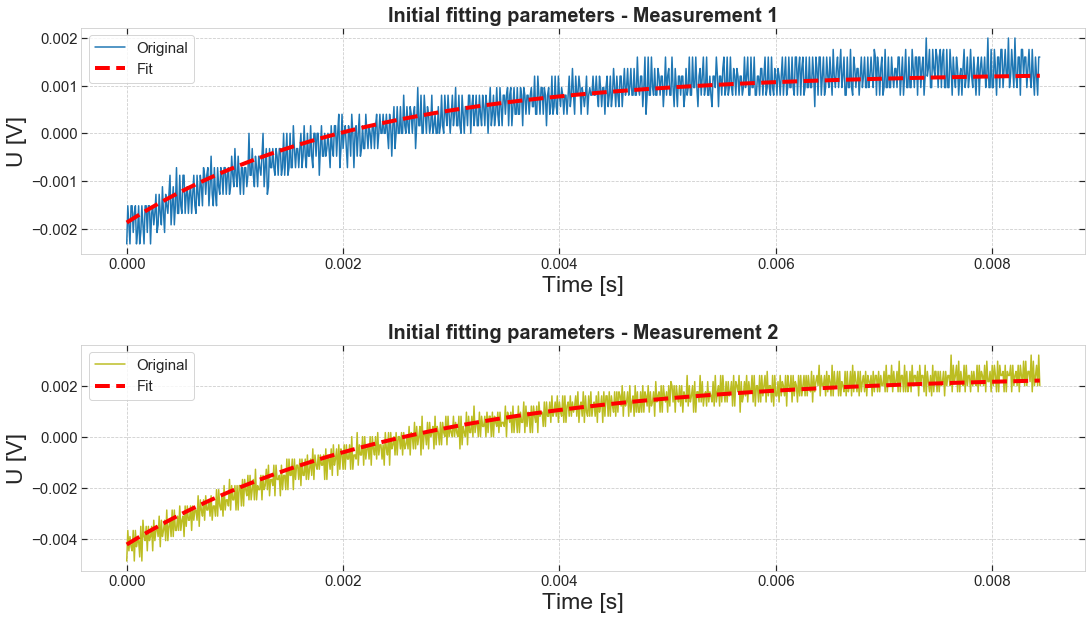

In [463]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:olive']
for idx, params in enumerate([[time_var_1, values_var_1, p0_1], [time_var_2, values_var_2, p0_2]]):
    axes[idx].plot(params[0], params[1],
                   color=colors[idx], label='Original')
    axes[idx].plot(params[0], fit_func(params[0], *params[2]),
                   c='red', linestyle='--', lw=4, label='Fit', zorder=2)

    axes[idx].set_title('Initial fitting parameters - Measurement {0}'.format(idx+1),
                        fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper left', fontsize=legendsize)

plt.show()

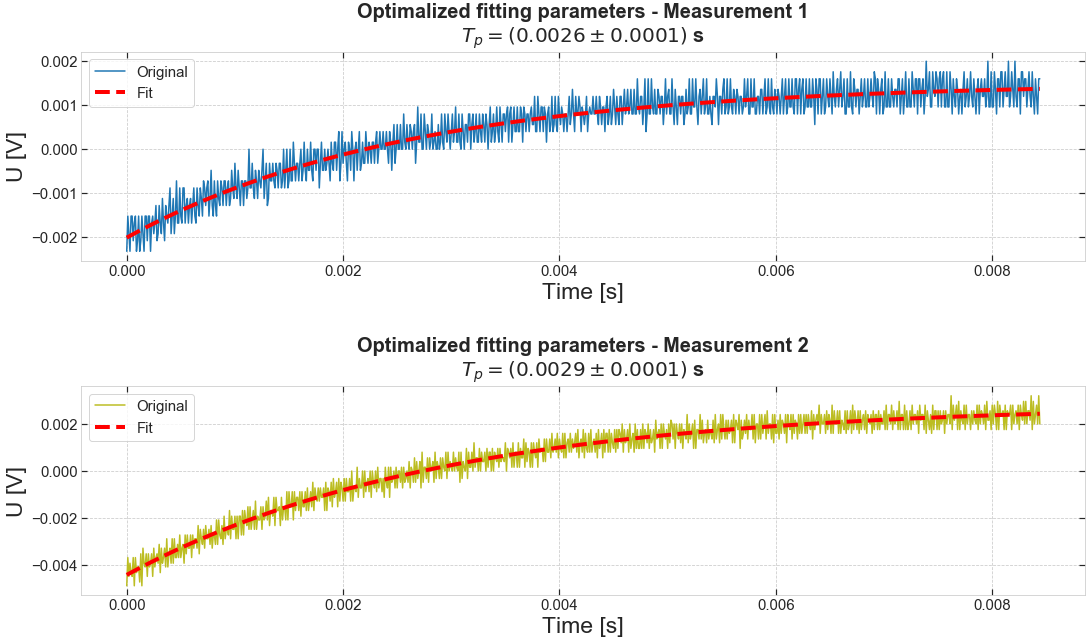

In [464]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))
fig.subplots_adjust(hspace=0.6)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:olive']
for idx, params in enumerate([[time_var_1, values_var_1, popt_1, perr_1], [time_var_2, values_var_2, popt_2, perr_2]]):
    axes[idx].plot(params[0], params[1],
                   color=colors[idx], label='Original')
    axes[idx].plot(params[0], fit_func(params[0], *params[2]),
                   c='red', linestyle='--', lw=4, label='Fit', zorder=2)
    
    # Characteristic time of pumping (T_p)
    chart = -1/params[2][2]
    perr_chart = (params[3][2]/params[2][2]) * chart
    
    axes[idx].set_title(('Optimalized fitting parameters - Measurement {0}\n'.format(idx+1) +
                         '$T_p = \\left( {0:.4f} \pm {1:.4f} \\right)$ s'.format(chart, np.abs(perr_chart))),
                        fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper left', fontsize=legendsize)

plt.show()

#### 2) Cut + Low pass filter

In [465]:
p0_1 = value_prep(time=time_var_1, values=output_var_1, prep=10, offset=0)
popt_1, pcov_1 = curve_fit(fit_func, time_var_1, output_var_1, p0=p0_1)
perr_1 = np.sqrt(np.diag(pcov_1))
p0_2 = value_prep(time=time_var_2, values=output_var_2, prep=10, offset=0)
popt_2, pcov_2 = curve_fit(fit_func, time_var_2, output_var_2, p0=p0_2)
perr_2 = np.sqrt(np.diag(pcov_2))

# REPORTING AFTER FITTING
# Measurement 1
print(b1 + 'Starting equation (Meas. 1)' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0_1[0], p0_1[1], p0_1[2]))
print(b1 + 'Final equation (Meas. 1)' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                                        '({2:.5f} +- {3:.5f}) * ' +
                                                        'e^(({4:.5f} +- {5:.5f}) * t)').format(popt_1[0], perr_1[0],
                                                                                               popt_1[1], perr_1[1],
                                                                                               popt_1[2], perr_1[2]))
chart_1 = -1/popt_1[2]
perr_chart_1 = (perr_1[2]/popt_1[2]) * chart_1
print(b1 + 'Characteristic time (Meas. 1)' + b0 + ' : T_p = ({0:.5e} +- {1:.5e}) s'.format(chart_1, np.abs(perr_chart_1)))

print('\n')

# Measurement 2
print(b1 + 'Starting equation (Meas. 2)' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0_2[0], p0_2[1], p0_2[2]))
print(b1 + 'Final equation (Meas. 2)' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                                        '({2:.5f} +- {3:.5f}) * ' +
                                                        'e^(({4:.5f} +- {5:.5f}) * t)').format(popt_2[0], perr_2[0],
                                                                                               popt_2[1], perr_2[1],
                                                                                               popt_2[2], perr_2[2]))
chart_2 = -1/popt_2[2]
perr_chart_2 = (perr_2[2]/popt_2[2]) * chart_2
print(b1 + 'Characteristic time (Meas. 2)' + b0 + ' : T_p = ({0:.5e} +- {1:.5e}) s'.format(chart_2, np.abs(perr_chart_2)))

Starting equation (Meas. 1) : U(t) = 0.00133 + -0.00358 * e^(-468.43532 * t)
Final equation (Meas. 1) : U(t) = (0.00147 +- 0.00000) + (-0.00357 +- 0.00001) * e^((-403.93722 +- 1.85620) * t)
Characteristic time (Meas. 1) : T_p = (2.47563e-03 +- 1.13762e-05) s


Starting equation (Meas. 2) : U(t) = 0.00235 + -0.00711 * e^(-426.64825 * t)
Final equation (Meas. 2) : U(t) = (0.00275 +- 0.00001) + (-0.00730 +- 0.00001) * e^((-359.04135 +- 1.12659) * t)
Characteristic time (Meas. 2) : T_p = (2.78519e-03 +- 8.73934e-06) s


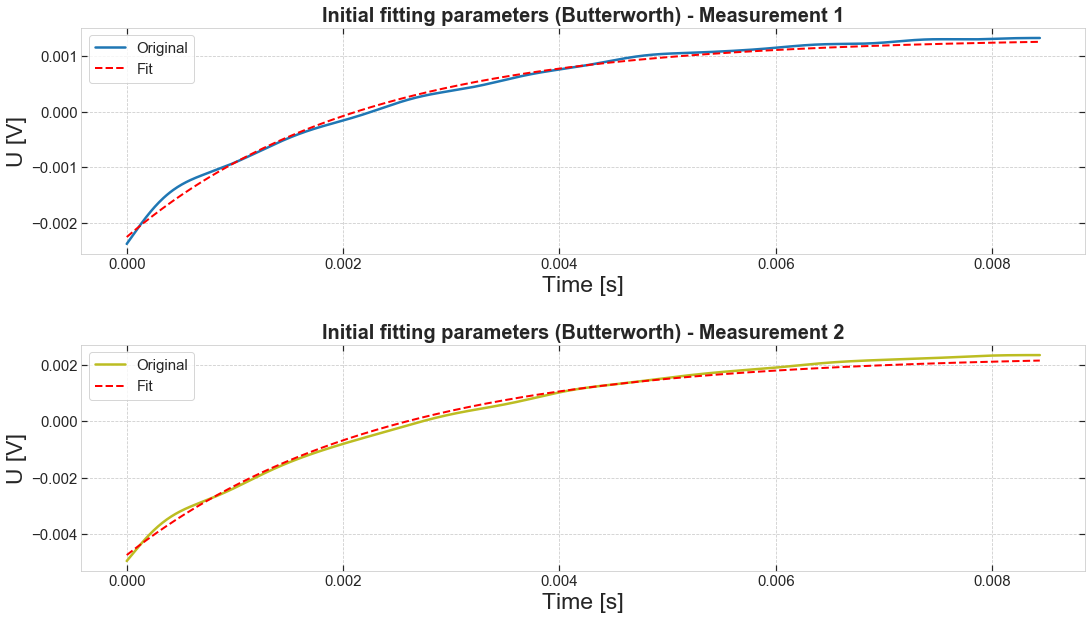

In [466]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:olive']
for idx, params in enumerate([[time_var_1, output_var_1, p0_1], [time_var_2, output_var_2, p0_2]]):
    axes[idx].plot(params[0], params[1],
                   lw=2.5, color=colors[idx], label='Original')
    axes[idx].plot(params[0], fit_func(params[0], *params[2]),
                   c='red', linestyle='--', lw=2, label='Fit', zorder=2)

    axes[idx].set_title('Initial fitting parameters (Butterworth) - Measurement {0}'.format(idx+1),
                        fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper left', fontsize=legendsize)

plt.show()

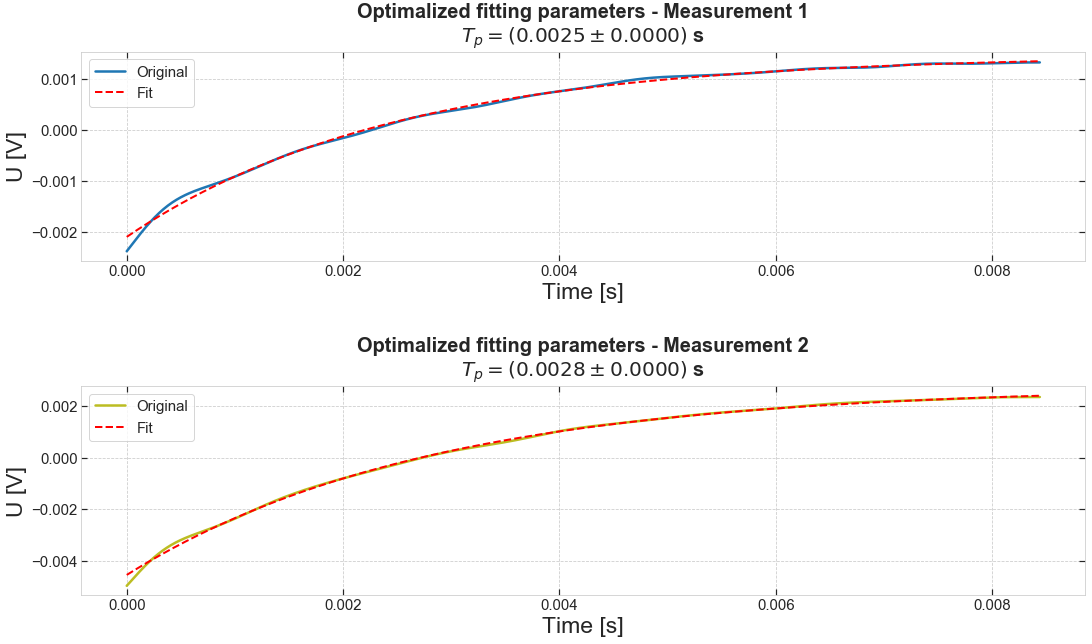

In [467]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))
fig.subplots_adjust(hspace=0.6)

titlesize = 20
axislabelsize = 23
axisticksize = 15
legendsize = 15

colors = ['tab:blue', 'tab:olive']
for idx, params in enumerate([[time_var_1, output_var_1, popt_1, perr_1], [time_var_2, output_var_2, popt_2, perr_2]]):
    axes[idx].plot(params[0], params[1],
                   lw=2.5, color=colors[idx], label='Original')
    axes[idx].plot(params[0], fit_func(params[0], *params[2]),
                   c='red', linestyle='--', lw=2, label='Fit', zorder=2)
    
    # Characteristic time of pumping (T_p)
    chart = -1/params[2][2]
    perr_chart = (params[3][2]/params[2][2]) * chart
    
    axes[idx].set_title(('Optimalized fitting parameters - Measurement {0}\n'.format(idx+1) +
                         '$T_p = \\left( {0:.4f} \pm {1:.4f} \\right)$ s'.format(chart, np.abs(perr_chart))),
                        fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[idx].legend(loc='upper left', fontsize=legendsize)

plt.show()

## 8 measurements of radiofrequency resonance

Magnetic induction in the midpoint of the Helmholtz coils:

$$
B = \frac{8}{\sqrt{125}} \frac{\mu_{0} n I}{R}
$$

Where in out case $R = 5.25\ \text{cm} = 0.0525\ \text{m}$ and $n = 224$.

In [468]:
radio = ['state_4_1.csv',
         'state_4_2.csv',
         'state_6_1.csv',
         'state_6_2.csv',
         'state_7_1.csv',
         'state_7_2.csv',
         'state_8_1.csv',
         'state_8_2.csv']

# Current of Helmholz coils, [I] = mA
current = [[221, 365],
           [220, 353],
           [133, 228],
           [222, 357]]
current_inv = [[298, 420],
               [293, 429],
               [206, 390],
               [298, 430]]
# Convert [I] to A from mA
current = np.array(current)/1e3
current_inv = np.array(current_inv)/1e3

# Radius of disk, [R] = m
R = 0.0525
n = 224
# Magnetic permeability, [mu_0] = T*m / A
mu_0 = 1.257e-06
B = 8/(np.sqrt(125)) * current * n * mu_0 / R
B_inv = 8/(np.sqrt(125)) * current_inv * n * mu_0 / R
B_0 = (B + B_inv) / 2
B_E = (B - B_inv) / 2

print(b1 + 'Effective magnetic field' + b0 + ' : B*_0 =  ({0:.4f} +- {1:.4f} muT)'.format(B_0.mean()*1e6, B_0.std()*1e6))
print(b1 + 'Magnetic field of Earth' + b0 + ' : B_E = ({0:.4f} +- {1:.4f} muT)'.format(B_E.mean()*1e6, B_E.std()*1e6))

Effective magnetic field : B*_0 =  (1166.3886 +- 296.3259 muT)
Magnetic field of Earth : B_E = (-159.5000 +- 58.5896 muT)


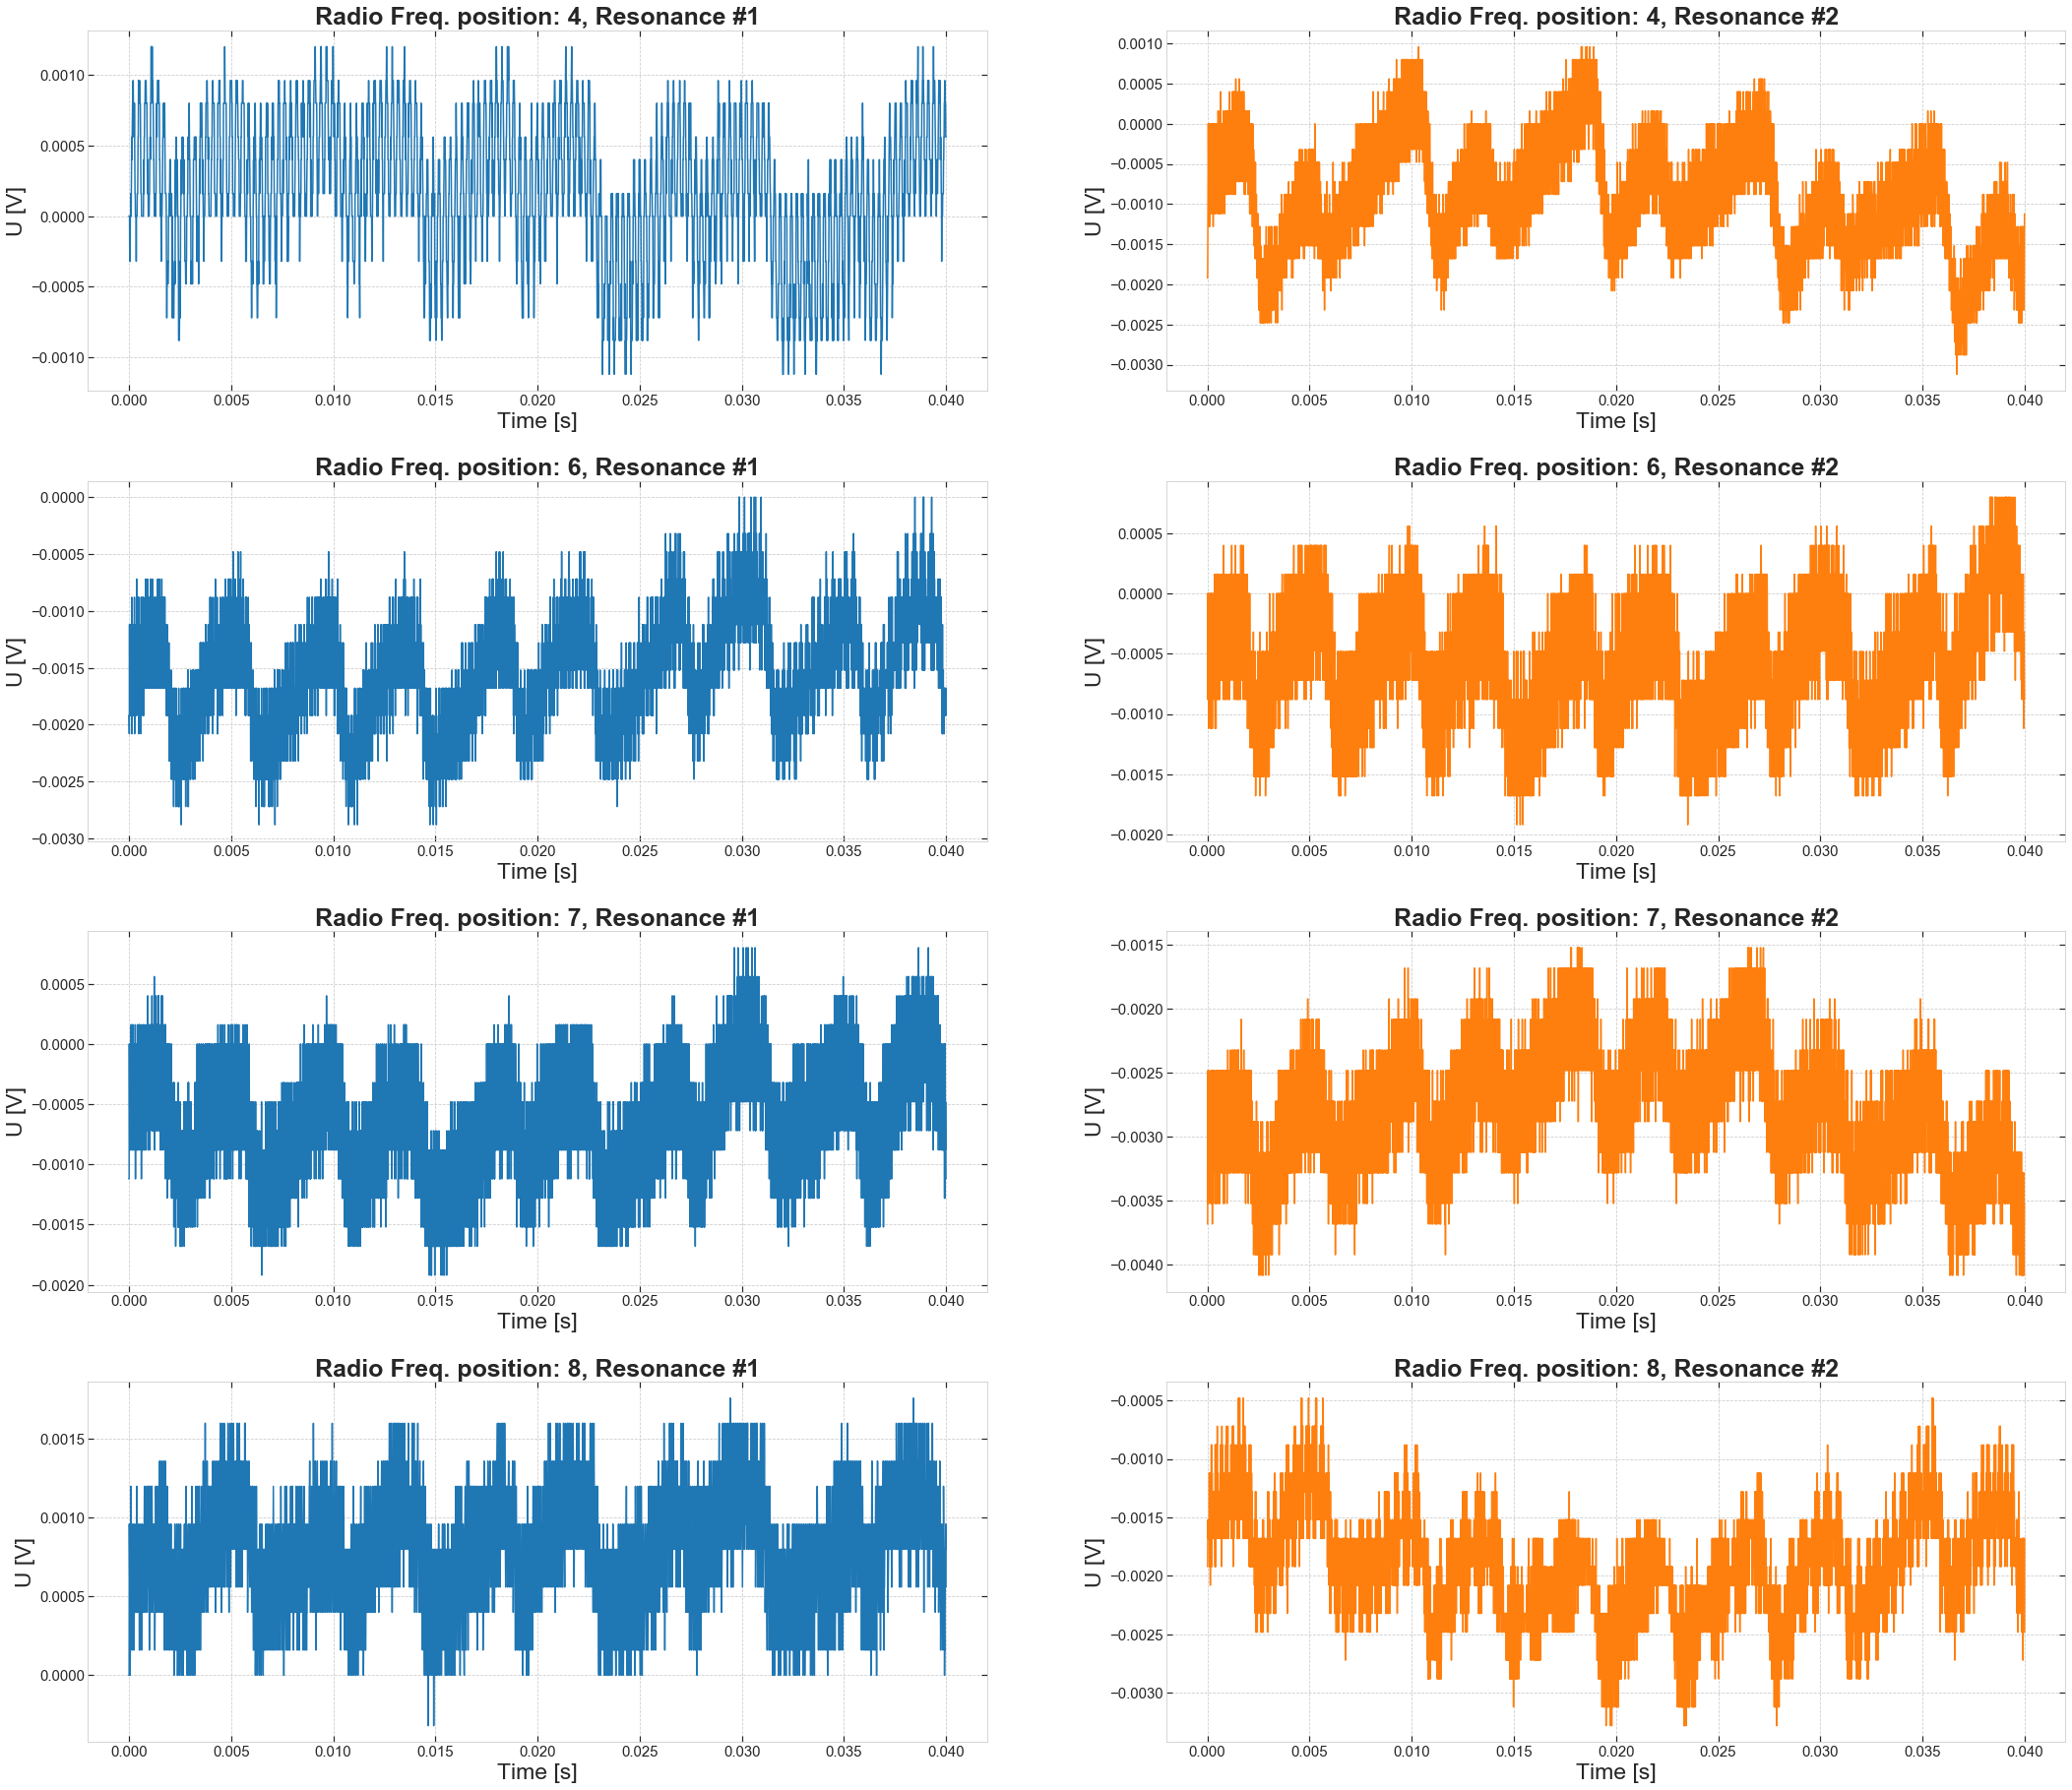

In [367]:
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*18, nrows*8))
fig.subplots_adjust(hspace=0.25)

titlesize = 25
axislabelsize = 23
axisticksize = 15

colors = ['tab:blue', 'tab:orange']
for idx, file in enumerate(radio):
    pos_row = idx//ncols
    pos_col = idx%ncols
    
    time, values, header = read_data_files(file=OPU_dir + file)
    
    axes[pos_row][pos_col].plot(time, values, lw=1.5, color=colors[pos_col])
    
    axes[pos_row][pos_col].set_title('Radio Freq. position: {0}, Resonance #{1}'.format(file.split('.')[0].split('_')[1],
                                                                       file.split('.')[0].split('_')[2]),
                                     fontsize=titlesize, fontweight='bold')
    
    axes[pos_row][pos_col].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[pos_row][pos_col].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[pos_row][pos_col].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'mag_resonance.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

## Magnetic field of Earth
### Measured dataset

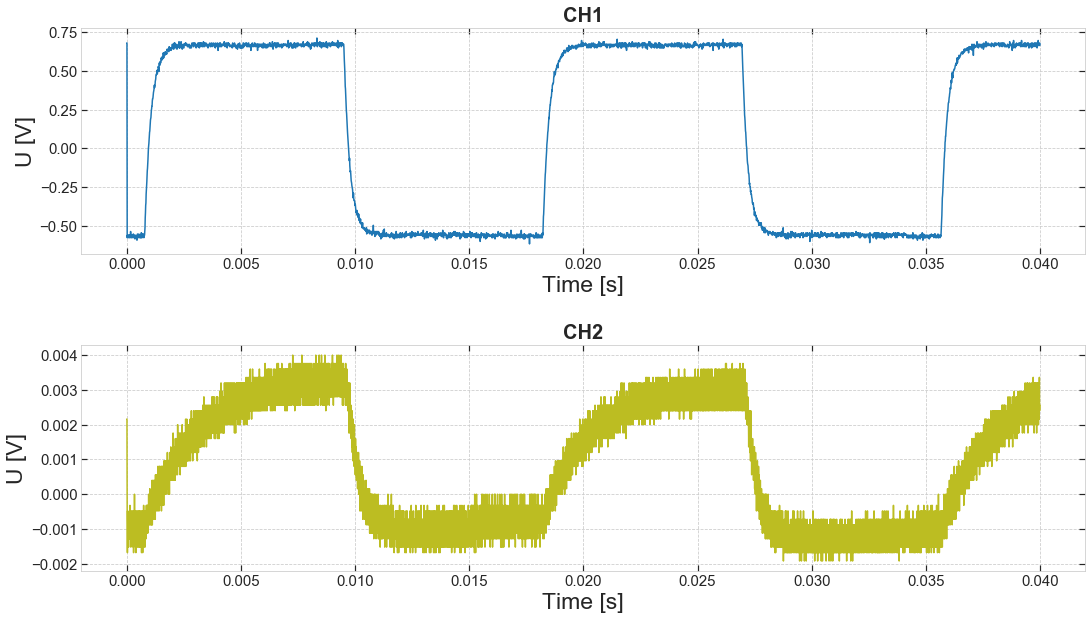

In [368]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))
fig.subplots_adjust(hspace=0.4)

titlesize = 20
axislabelsize = 23
axisticksize = 15

colors = ['tab:blue', 'tab:olive']
for idx, file in enumerate(['earth_mag_T.csv', 'earth_mag_1.csv']):
    time_mag, values_mag, header = read_data_files(file=OPU_dir + file)
    axes[idx].plot(time_mag, values_mag, color=colors[idx])

    axes[idx].set_title('CH{0}'.format(idx+1), fontsize=titlesize, fontweight='bold')
    axes[idx].set_xlabel('Time [s]', fontsize=axislabelsize)
    axes[idx].set_ylabel('U [V]', fontsize=axislabelsize)
    axes[idx].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

In [281]:
# Sampling frequency
fs = 1/float(header['Sampling Period'])
# Cut-off frequency of the filter
fc = 1000
# Normalize the frequency
w = fc / (fs / 2)
# Butterworth filter
b, a = signal.butter(5, w, 'low')
output_mag = signal.filtfilt(b, a, values_mag)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


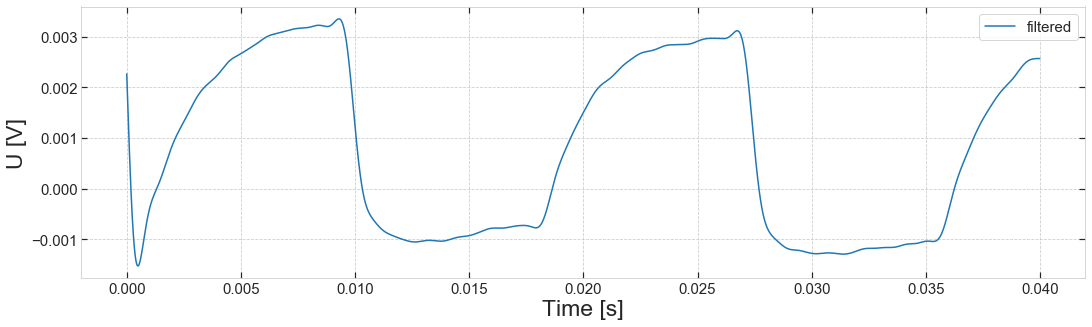

In [282]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 23
axisticksize = 15
legendize = 15

axes.plot(time_mag, output_mag, label='filtered')

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

### Cut signal
#### Original signal

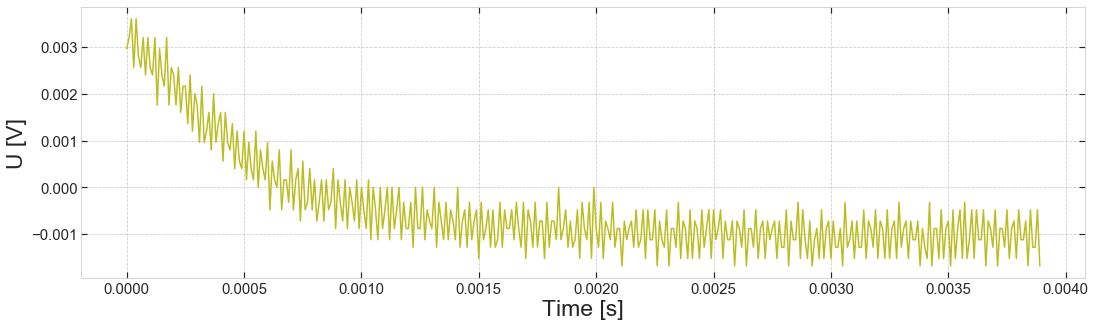

In [283]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows))

titlesize = 20
axislabelsize = 23
axisticksize = 15

time_mag, values_mag, _ = read_data_files(file=OPU_dir + 'earth_mag_1.csv')

lower = 960
upper = 1350
time_mag_var = np.array(time_mag[lower:upper])
time_mag_var -= np.min(time_mag_var)
values_mag_var = np.array(values_mag[lower:upper])

axes.plot(time_mag_var, values_mag_var, color='tab:olive')

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

#### LP Butterworth

In [284]:
# Sampling frequency
fs = 1/float(header['Sampling Period'])
# Cut-off frequency of the filter
fc_var = 5000
# Normalize the frequency
w_var = fc_var / (fs / 2)
# Butterworth filter
b_var, a_var = signal.butter(5, w_var, 'low')
output_mag_var = signal.filtfilt(b_var, a_var, values_mag_var)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


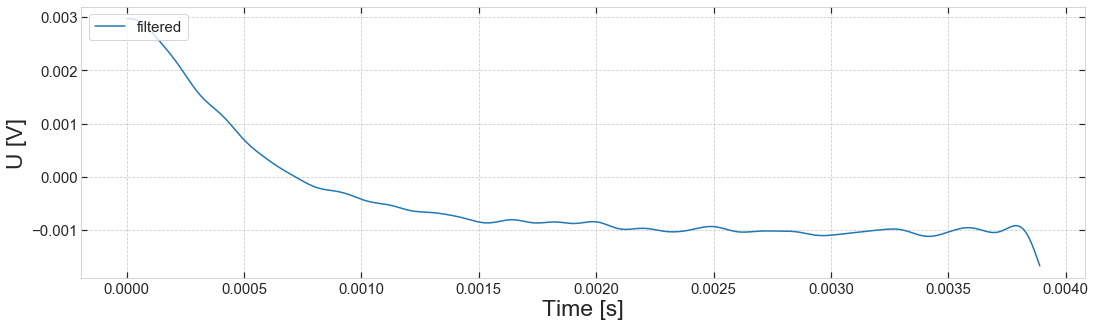

In [285]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 23
axisticksize = 15
legendize = 15

axes.plot(time_mag_var, output_mag_var, label='filtered')

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper left', fontsize=legendsize)
plt.show()

### Fit exponential on sliced signal
#### 1) Cut only

In [286]:
p0 = value_prep(time=time_mag_var, values=values_mag_var, prep=10, offset=0)
popt, pcov = curve_fit(fit_func, time_mag_var, values_mag_var, p0=p0)
perr = np.sqrt(np.diag(pcov))

print(b1 + 'Starting equation' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0[0], p0[1], p0[2]))
print(b1 + 'Final equation' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                              '({2:.5f} +- {3:.5f}) * ' +
                                              'e^(({4:.5f} +- {5:.5f}) * t)').format(popt[0], perr[0],
                                                                                     popt[1], perr[1],
                                                                                     popt[2], perr[2]))
chart = -1/popt[2]
perr_chart = (perr[2]/popt[2]) * chart
print(b1 + 'Characteristic time' + b0 + ' : T_2 = ({0:.5e} +- {1:.5e}) s'.format(chart, np.abs(perr_chart)))

Starting equation : U(t) = -0.00103 + 0.00404 * e^(-1570.68470 * t)
Final equation : U(t) = (-0.00104 +- 0.00003) + (0.00457 +- 0.00012) * e^((-1935.20558 +- 87.57971) * t)
Characteristic time : T_2 = (5.16741e-04 +- 2.33856e-05) s


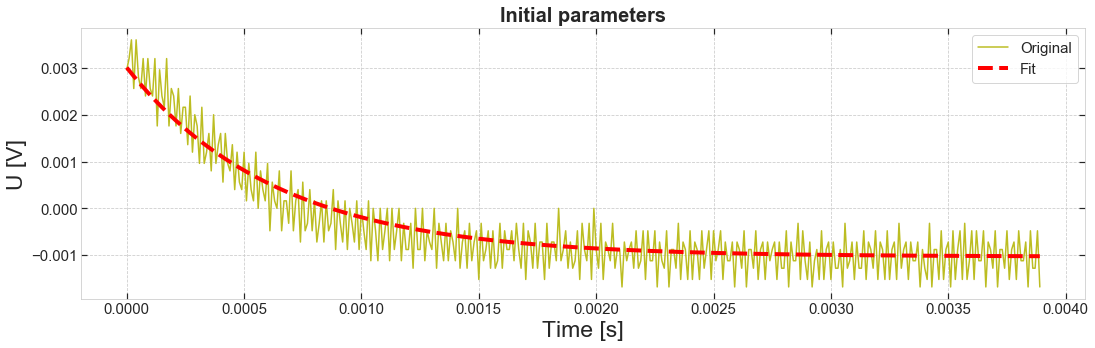

In [287]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,5))

titlesize=20
axislabelsize = 23
axisticksize = 15

axes.plot(time_mag_var, values_mag_var, label='Original', color='tab:olive')
axes.plot(time_mag_var, fit_func(time_mag_var, *p0),
          c='red', linestyle='--', lw=4, label='Fit', zorder=2)

axes.set_title('Initial parameters', fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

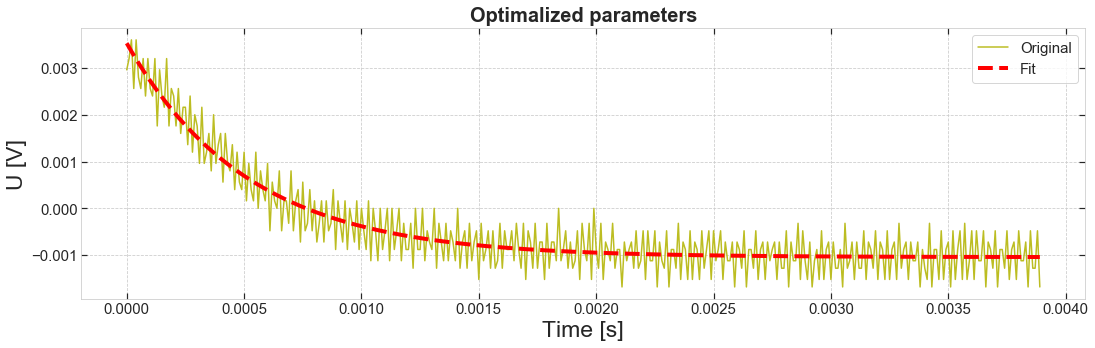

In [288]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,5))

titlesize = 20
axislabelsize = 23
axisticksize = 15

axes.set_title('Optimalized parameters', fontsize=titlesize, fontweight='bold')
axes.plot(time_mag_var, values_mag_var, label='Original', color='tab:olive')
axes.plot(time_mag_var, fit_func(time_mag_var, *popt),
          c='red', linestyle='--', lw=4, label='Fit', zorder=2)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

#### 2) Cut + Low pass filter

In [289]:
p0 = value_prep(time=time_mag_var, values=output_mag_var, prep=10, offset=0)
popt, pcov = curve_fit(fit_func, time_mag_var, output_mag_var, p0=p0)
perr = np.sqrt(np.diag(pcov))

print(b1 + 'Starting equation' + b0 + (' : U(t) = {0:.5f} + ' +
                                                 '{1:.5f} * ' +
                                                 'e^({2:.5f} * t)').format(p0[0], p0[1], p0[2]))
print(b1 + 'Final equation' + b0 + (' : U(t) = ({0:.5f} +- {1:.5f}) + ' +
                                              '({2:.5f} +- {3:.5f}) * ' +
                                              'e^(({4:.5f} +- {5:.5f}) * t)').format(popt[0], perr[0],
                                                                                     popt[1], perr[1],
                                                                                     popt[2], perr[2]))
chart = -1/popt[2]
perr_chart = (perr[2]/popt[2]) * chart
print(b1 + 'Characteristic time' + b0 + ' : T_2 = ({0:.5e} +- {1:.5e}) s'.format(chart, np.abs(perr_chart)))

Starting equation : U(t) = -0.00122 + 0.00413 * e^(-1223.63368 * t)
Final equation : U(t) = (-0.00105 +- 0.00001) + (0.00453 +- 0.00002) * e^((-1901.45602 +- 18.14366) * t)
Characteristic time : T_2 = (5.25913e-04 +- 5.01825e-06) s


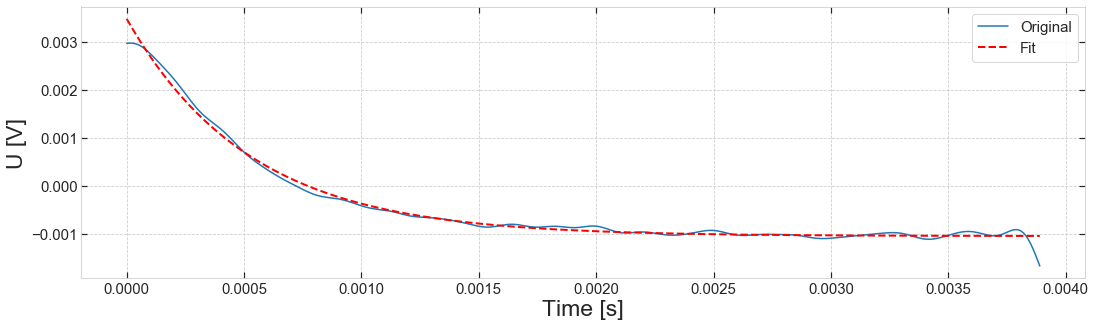

In [290]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,5))

axislabelsize = 23
axisticksize = 15

axes.plot(time_mag_var, output_mag_var, label='Original')
axes.plot(time_mag_var, fit_func(time_mag_var, *popt),
          c='red', linestyle='--', lw=2, label='Fit', zorder=2)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

### Find minimum error of fit

In [291]:
time_mag, values_mag, _ = read_data_files(file=OPU_dir + 'earth_mag_1.csv')
perr_values = []
up_min = 1100
up_max = 1410
for upper in range(up_min, up_max):

    time_mag_var = np.array(time_mag[lower:upper])
    time_mag_var -= np.min(time_mag_var)
    values_mag_var = np.array(values_mag[lower:upper])
    
    p0 = value_prep(time=time_mag_var, values=values_mag_var, prep=10, offset=0)
    popt, pcov = curve_fit(fit_func, time_mag_var, values_mag_var, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    perr_values.append(perr)
    
perr_values = np.array(perr_values)

c:\users\lordpb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\lordpb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
c:\users\lordpb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


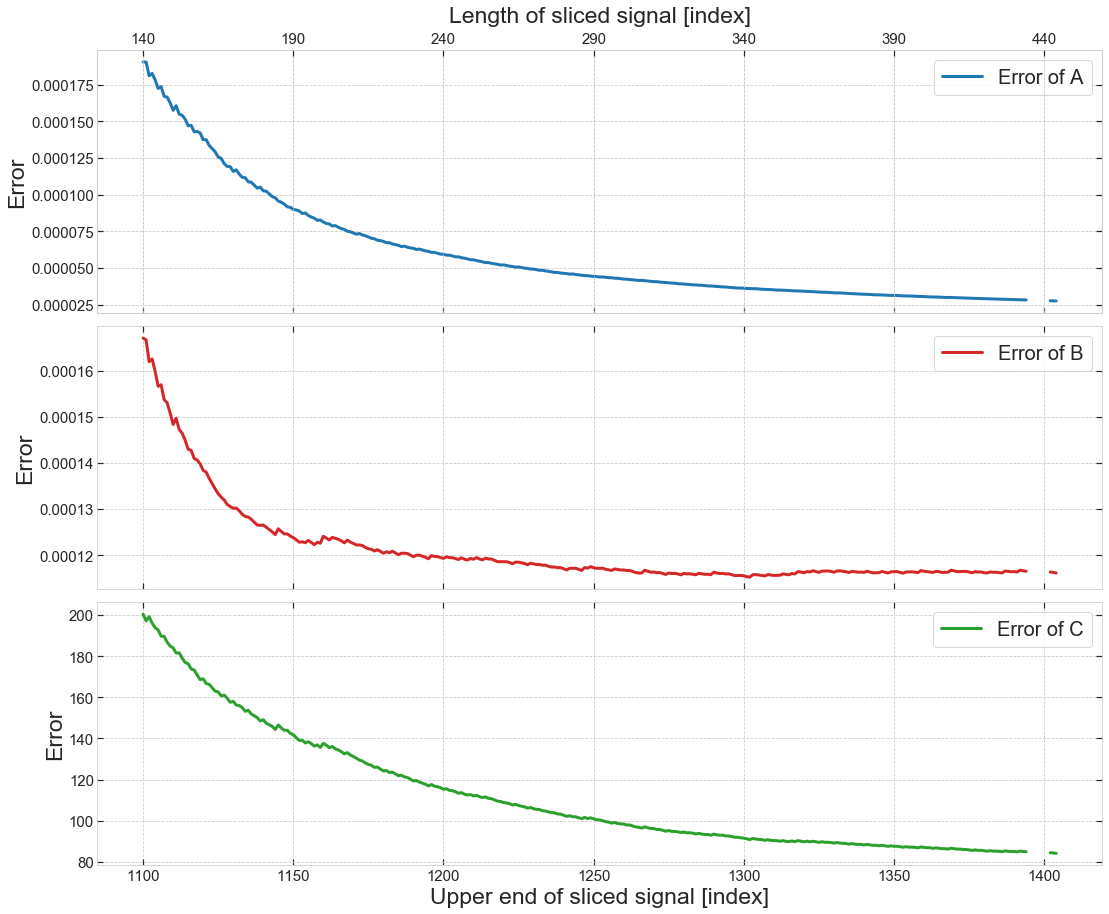

In [292]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols, 5*nrows), sharex=True)
fig.subplots_adjust(hspace=0.05)

axislabelsize = 23
axisticksize = 15
legendsize = 20

colors = ['tab:blue','tab:red','tab:green']
labels = ['A', 'B', 'C']
x1_ticks = [i for i in range(up_min, up_max)]

for i in range(nrows):
    axes[i].plot(x1_ticks, perr_values[:,i], lw=3,
                 color=colors[i], label='Error of {0}'.format(labels[i]))
    axes[i].set_ylabel('Error', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
    axes[i].legend(loc='upper right', fontsize=legendsize)
axes[-1].set_xlabel('Upper end of sliced signal [index]', fontsize=axislabelsize)


# Second X-axis
axis_x2 = axes[0].twiny()
new_tick_locations = axes[2].get_xticks()[1:-1]
x2_ticks = [int(x1 - lower) for x1 in new_tick_locations]

axis_x2.set_xlim(axes[2].get_xlim())
axis_x2.set_xticks(new_tick_locations)
axis_x2.set_xticklabels(x2_ticks)
axis_x2.set_xlabel('Length of sliced signal [index]', fontsize=axislabelsize, labelpad=10)
axis_x2.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()